In [1]:
!pip install sagemaker==1.72.0 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [101]:
%matplotlib inline
import os
import ast
import json
import numpy as np
import pandas as pd
import source

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.estimator import SKLearn
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

session = sagemaker.Session()
role = get_execution_role()

from IPython.display import Audio
sound_file = './sound/beep.wav'

In [223]:
data_df = pd.read_csv("./data/processed_data.csv")

<h2> Train and Test Set </h2>

Before moving on to modelling, let us define the training and test set. In this project, we will be trading from April 27, 2017 onwards. Therefore, training set will include all data *before* this cutoff date, while test set will include all data *after* this cutoff date.

Furthermore, I will limiting the universe of the cryptocurrency to the top 10 currency by ranking as of the end of training, April 26, 2017.

Unfortunate, since our features set is generated based on the value of $w$ we choose, we cannot separate the the training and test set using the raw data. Therefore, we will create a function to do this. For now, we can find the top 10 currency first.

In [224]:
# end_of_training_data = data_df[data_df['time'] == '2016-04-26']
end_of_training_data = data_df[data_df['time'] == '2017-10-24']
# top_20 = end_of_training_data.nsmallest(columns='rank', n=0)['sym'].values
top_20 = ['AMP', 'AUR', 'BLK', 'BTC', 'BTCD', 'BTS', 'CREVA', 'DASH', 'DCR',
       'DOGE', 'ETH', 'FCT', 'FTC', 'IFC', 'LTC', 'MAID', 'MEC', 'NMC', 'NVC',
       'NXT', 'PPC', 'QRK', 'RVR', 'STEEM', 'USNBT', 'VASH', 'VOX', 'VRC',
       'VTC', 'WDC', 'XCP', 'XEM', 'XLM', 'XMR', 'XPM', 'XPY', 'XRP', 'ZET']
data_df = data_df[data_df['sym'].isin(top_20)].reset_index(drop=True)

START_TEST = pd.Timestamp('2017-10-25')
START_VAL = pd.Timestamp('2016-10-25')

In [225]:
data_df.sym.unique()

array(['AMP', 'AUR', 'BLK', 'BTC', 'BTCD', 'BTS', 'CREVA', 'DASH', 'DCR',
       'DOGE', 'ETH', 'FCT', 'FTC', 'IFC', 'LTC', 'MAID', 'MEC', 'NMC',
       'NVC', 'NXT', 'PPC', 'QRK', 'RVR', 'STEEM', 'USNBT', 'VASH', 'VOX',
       'VRC', 'VTC', 'WDC', 'XCP', 'XEM', 'XLM', 'XMR', 'XPM', 'XPY',
       'XRP', 'ZET'], dtype=object)

We will be experimenting with the following algorithms for the model:
1. XGBoost
2. Simple Custom Neural Net
3. Long Short Term Memory Networks

Before I work with these models, I will start with the benchmark model first which is based on Simple Moving Average model.

<h2> Simple Moving Average (SMA)</h2>

In Simple Moving Average, the predicted next price is equal to the average of the last $w$ data points. In addition to creating this model, I will be creating the function to implement the trading strategy in this section as well.

In [226]:
# Since our create_features function calculate the average of the last w prices as one of our features, we can reuse it to perform SMA
def predict_sma(features_df, w):
    return features_df.groupby('sym')['target'].shift(1).rolling(w).mean()

# Function to calculate Root Mean Squared of Error, an useful metric to gauge how accurate the model is
def calculate_mape(asset_matrix):
    asset_matrix['error'] = abs(1 - (asset_matrix['predicted_price']/asset_matrix['actual_price'])) * 100
    mape = sum(asset_matrix['error'])/len(asset_matrix)
    print('MAPE: {:.4f}'.format(mape))
    return mape

# Function to create a dataframe containing calculations needed to execute the trading strategy
def construct_asset_matrix(test_df, pred, pred_type='price'):
    result = test_df.copy()
    
    if pred_type == 'price':
#         result['']
#         result = result[['sym', 'price_4_last', 'target']]
#         result.columns = ['sym', 'previous_price', 'actual_price']
        result['previous_price'] = result.groupby('sym')['target'].shift(1)
        result['actual_price'] = result['target']
        result['predicted_price'] = pred.values
        result['predicted_roi'] = result['predicted_price']/result['previous_price'] - 1
        result['actual_roi'] = result['actual_price']/result['previous_price'] - 1
        
        return result[['sym', 'predicted_price', 'actual_price', 'predicted_roi', 'actual_roi']]
    else:
        result['previous_roi'] = result.groupby('sym')['target'].shift(1)
        result['actual_roi'] = result['target']
        result['predicted_roi'] = pred.values
#         result = result[['sym', 'price_4_last', 'market_cap_4_last', 'target']]
#         result.columns = ['sym', 'previous_price', 'previous_market_cap', 'actual_roi']
#         result['expected_roi'] = pred.values
#         result['predicted_price'] = result['previous_price'] * (1 + result['expected_roi'])
#         result['actual_price'] = result['previous_price'] * (1 + result['actual_roi'])
        
        return result[['sym', 'predicted_roi', 'actual_roi']]

# Function to plot predicted vs actual price for a given asset using asset matrix
def plot_predicted_vs_actual(asset_matrix, sym):
    plt.figure(figsize=(10,5))
    try:
        asset_matrix[asset_matrix['sym'] == sym]['predicted_price'].plot(label='Prediction', lw=1)
        asset_matrix[asset_matrix['sym'] == sym]['actual_price'].plot(label='Actual', lw=1)
    except:
        asset_matrix[asset_matrix['sym'] == sym]['predicted_roi'].plot(label='Prediction', lw=1)
        asset_matrix[asset_matrix['sym'] == sym]['actual_roi'].plot(label='Actual', lw=1)                                                              

    plt.legend()
    plt.show()

In [227]:
sma_features = source.create_features(data_df, w=0)
sma_pred = predict_sma(sma_features, w=5)

['age_4_last', 'age_5_delta', 'volume_4_last', 'volume_5_delta', 'roi_4_last', 'roi_5_delta', 'price_4_last', 'price_5_delta', 'rank_4_last', 'rank_5_delta', 'market_cap_4_last', 'market_cap_5_delta']


In [228]:
asset_matrix = construct_asset_matrix(sma_features, sma_pred)

<h2>Trading Strategy</h2>

Now that we have the predicted price for a given time period, we can build a portfolio at each time step so that we can have an idea how much profit can be generated by using the SMA prediction model. The strategy employed to build the portfolio will be standardized accross all the different prediction model we will explore later as well.

The strategy will be to invest in the top $n$ coins with the highest expected ROI and then sell it the following day. To simplify the calculation, we will be ignoring the transaction cost. As the algorithm continues to trade, it will re-evaluate the best value of $n$ for a given time period such that it maximizes the Sharpe ratio based on the predicted prices on the next time step.

We will be trading for 1 year from April 12, 2017 and April 12, 2018.

In [229]:
test_features_df = source.create_features(data_df, w=0)
test_sma_pred = predict_sma(test_features_df, w=3)
# test_sma_df = test_features_df[pd.to_datetime(test_features_df.index) >= START_TEST]
# test_sma_pred = predict_sma(test_sma_df, w=5)
test_asset_matrix = construct_asset_matrix(test_features_df, test_sma_pred)
test_asset_matrix = test_asset_matrix[pd.to_datetime(test_asset_matrix.index) >= START_TEST]

['age_4_last', 'age_5_delta', 'volume_4_last', 'volume_5_delta', 'roi_4_last', 'roi_5_delta', 'price_4_last', 'price_5_delta', 'rank_4_last', 'rank_5_delta', 'market_cap_4_last', 'market_cap_5_delta']


In [230]:
test_features_df['sym'].unique()

array(['AMP', 'AUR', 'BLK', 'BTC', 'BTCD', 'BTS', 'CREVA', 'DASH', 'DCR',
       'DOGE', 'ETH', 'FCT', 'FTC', 'IFC', 'LTC', 'MAID', 'MEC', 'NMC',
       'NVC', 'NXT', 'PPC', 'QRK', 'RVR', 'STEEM', 'USNBT', 'VASH', 'VOX',
       'VRC', 'VTC', 'WDC', 'XCP', 'XEM', 'XLM', 'XMR', 'XPM', 'XPY',
       'XRP', 'ZET'], dtype=object)

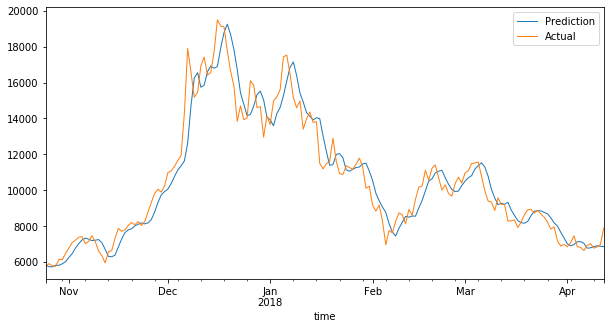

In [231]:
plot_predicted_vs_actual(test_asset_matrix, 'BTC')

In [232]:
# Function to update mean based on new value
def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

# Function to execute the trading strategy over the trading horizon using asset matrix
def evaluate_strategy(asset_matrix, n=10):
    initial_value = 10000
    total_value = initial_value
    sharpe_ratio = None
    mean_roi = 0
    std_roi = 0
    t = 1
    percent_returns = 0
    value_history = []
    roi_history = []
    top_roi = []

    dates = list(set(asset_matrix.index))
    dates.sort()

    for date in dates:
#         print(date)

        coins_stats_df = asset_matrix[asset_matrix.index == date]
        coins_stats_df = coins_stats_df.sort_values(by='predicted_roi', ascending=False)
        coins_stats_df = coins_stats_df[coins_stats_df['predicted_roi'] > 0]
#         print(coins_stats_df)
        
        if coins_stats_df.empty:
#         if len(coins_stats_df) == 0:
            prev_mean_roi = mean_roi
            mean_roi = update_mean(prev_mean_roi, t, 0)
            std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, 0)
            value_history.append(total_value)
            roi_history.append(0)
            continue
        
        day_return = sum(coins_stats_df.iloc[:n,:]['actual_roi'] * total_value / n)
        day_roi = day_return/total_value
        total_value += day_return
        percent_returns = (total_value/initial_value - 1) * 100

        prev_mean_roi = mean_roi
        mean_roi = update_mean(prev_mean_roi, t, day_roi)
        std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, day_roi)
        sharpe_ratio = mean_roi/std_roi
        
        value_history.append(total_value)
        roi_history.append(day_roi)

        t += 1
        
    print('Cumulative Returns: {:.2e}%, Sharpe Ratio: {:.4f}'.format(percent_returns, sharpe_ratio))
    
    history = pd.concat([pd.DataFrame(dates), pd.DataFrame(value_history), pd.DataFrame(roi_history)], axis=1)
    history.columns = ['time', 'total_value', 'roi']
    history = history.set_index('time')
    return sharpe_ratio, percent_returns, history

In [233]:
sma_result = evaluate_strategy(test_asset_matrix)

Cumulative Returns: 4.10e+03%, Sharpe Ratio: 0.2907


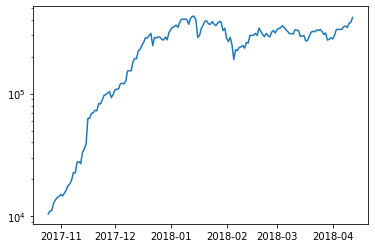

In [234]:
plt.plot(sma_result[2]['total_value'])
plt.yscale('log')
plt.show()

<h2> XGBoost </h2>

Testing on XGBoost algorithm. We will experiment using different values of $w$.

In [244]:
def run_xgboost_model(w, hyperparams, prefix, data_dir, data_df, target='price'):
    
    features_df = source.create_features(data_df, w, target=target)
    features_df = features_df[features_df['sym'] == 'BTC']
    
    train_df = features_df[features_df.index < START_VAL]
    val_df = features_df[(features_df.index >= START_VAL) & (features_df.index < START_TEST)]
    test_df = features_df[features_df.index >= START_TEST]
    
    X_train = pd.DataFrame(train_df.iloc[:,2:-2])
    Y_train = pd.DataFrame(train_df['target'])
    
    X_val = pd.DataFrame(val_df.iloc[:,2:-2])
    Y_val = pd.DataFrame(val_df['target'])
    
    X_test = pd.DataFrame(test_df.iloc[:,2:-2])
    Y_test = pd.DataFrame(test_df['target'])
    
    pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
    pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'val.csv'), header=False, index=False)

    train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
    val_location = session.upload_data(os.path.join(data_dir, 'val.csv'), key_prefix=prefix)
    
    container = get_image_uri(session.boto_region_name, 'xgboost')

#     xgb_custom = sagemaker.estimator.Estimator(container, # The name of the training container
#                                         role,      # The IAM role to use (our current role in this case)
#                                         train_instance_count=1, # The number of instances to use for training
#                                         train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
#                                         output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
#                                         # Where to save the output (the model artifacts)
#                                         sagemaker_session=session) # The current SageMaker session


    script_path = './source/custom_xgb.py'

    xgb_custom = XGBoost(entry_point=script_path,
                        framework_version='1.0-1',
                        hyperparameters=hyperparams,
                        role=role,
                        train_instance_count=1,
                        train_instance_type='ml.m4.xlarge',
                        output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix))
    
#     xgb_custom.set_hyperparameters(max_depth=10,
#                                 eta=0.2,
#                                 gamma=4,
#                                 min_child_weight=1,
#                                 subsample=0.8,
#                                 objective='reg:linear',
#                                 early_stopping_rounds=10,
#                                 num_round=200)
    
    s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')
    xgb_custom.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    predictor = xgb_custom.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
    
#     return predictor, X_test
    pred = []
    i = 0
    payload_list = [[str(entry) for entry in row] for row in X_test.values]

    for j in range(10000,len(payload_list)+10000, 10000):
        max_idx = min(len(payload_list), j)
        payload = '\n'.join([','.join(row) for row in payload_list[i:j]])
        response = session.sagemaker_runtime_client.invoke_endpoint(
                                                        EndpointName = predictor.endpoint, 
                                                        ContentType = 'text/csv',
                                                        Body = payload)
        result = response['Body'].read().decode("utf-8")
        pred_val = ast.literal_eval(result)
        try:
            pred = pred + pred_val
        except:
            pred = pred + list(pred_val)
        i = j
    
    asset_matrix = construct_asset_matrix(test_df, pd.DataFrame(pred), pred_type=target)
    
    
    result = evaluate_strategy(asset_matrix)
    
    session.sagemaker_client.delete_endpoint(EndpointName = predictor.endpoint)
    
    return asset_matrix, result
    

In [245]:
hyperparams = {
        "max_depth": "1000",
        "eta": "0.2",
        "gamma": "0",
        "min_child_weight": "1",
        "subsample": "0.8",
        "objective": "reg:squarederror",
        "num_round": "100",
        "verbosity": "0",
        "early_stopping_rounds": "10",
        "disable": '1'
}

In [246]:
xgb_w7_roi = run_xgboost_model(w=7, 
                          hyperparams=hyperparams, 
                          prefix='xgb-w7-roi', 
                          data_dir='./data', 
                          data_df=data_df,
                          target='price')

['age_1_mean', 'age_3_stdev', 'age_5_delta', 'volume_2_median', 'volume_3_stdev', 'volume_4_last', 'volume_5_delta', 'roi_1_mean', 'roi_2_median', 'roi_3_stdev', 'roi_5_delta', 'price_2_median', 'price_3_stdev', 'price_5_delta', 'rank_1_mean', 'rank_3_stdev', 'rank_5_delta', 'market_cap_2_median', 'market_cap_3_stdev', 'market_cap_5_delta']


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-02-03 14:38:59 Starting - Starting the training job...
2021-02-03 14:39:00 Starting - Launching requested ML instances......
2021-02-03 14:40:05 Starting - Preparing the instances for training..............................
2021-02-03 14:45:15 Downloading - Downloading input data
2021-02-03 14:45:15 Training - Downloading the training image.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module custom_xgb does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python -m pip install . 
Processing /opt/ml/code
  Created wheel for custom-xgb: filename=custom_xgb-1.0.0-py2.py3-none-any.whl size=6027 sha256=d1

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 185
Billable seconds: 185
-------------!

TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
# features_df = None

In [ ]:
# w=5
# target='roi'
# data_dir='./data'
# prefix='xgb-w5'

# features_df = source.create_features(data_df, w, target=target)
# features_df = features_df[features_df['sym'] == 'BTC']
# # features_df['target'] = features_df['target']*100

# train_df = features_df[features_df.index < START_VAL]
# val_df = features_df[(features_df.index >= START_VAL) & (features_df.index < START_TEST)]
# test_df = features_df[features_df.index >= START_TEST]

# X_train = pd.DataFrame(train_df.iloc[:,1:-1])
# Y_train = pd.DataFrame(train_df['target'])

# X_val = pd.DataFrame(val_df.iloc[:,1:-1])
# Y_val = pd.DataFrame(val_df['target'])

# X_test = pd.DataFrame(test_df.iloc[:,1:-1])
# Y_test = pd.DataFrame(test_df['target'])

# pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
# pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'val.csv'), header=False, index=False)

# train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
# val_location = session.upload_data(os.path.join(data_dir, 'val.csv'), key_prefix=prefix)

# container = get_image_uri(session.boto_region_name, 'xgboost')

# s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
# s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='text/csv')

In [ ]:
# train_features = X_train.values
# train_labels = Y_train.values
# test_features = X_test.values
# test_labels = Y_test.values

In [ ]:
# train_features

In [ ]:
# features_df[['roi_1_mean', 'roi_2_median', 'roi_3_stdev', 'roi_5_delta', 'target']].corr().abs().round(2)

In [ ]:
# xgb_custom = sagemaker.estimator.Estimator(container, # The name of the training container
#                                     role,      # The IAM role to use (our current role in this case)
#                                     train_instance_count=1, # The number of instances to use for training
#                                     train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
#                                     output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
#                                     # Where to save the output (the model artifacts)
#                                     sagemaker_session=session) # The current SageMaker session

# xgb_custom.set_hyperparameters(max_depth=20,
#                                 eta=0.2,
#                                 gamma=1,
#                                 min_child_weight=2,
#                                 subsample=0.8,
#                                 objective='reg:linear',
#                                 early_stopping_rounds=20,
#                                 num_round=200)

# xgb_custom.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
# predictor = xgb_custom.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

In [ ]:
# pred = []
# i = 0
# payload_list = [[str(entry) for entry in row] for row in X_train.values]

# for j in range(10000,len(payload_list)+10000, 10000):
#     max_idx = min(len(payload_list), j)
#     payload = '\n'.join([','.join(row) for row in payload_list[i:j]])
#     response = session.sagemaker_runtime_client.invoke_endpoint(
#                                                     EndpointName = predictor.endpoint, 
#                                                     ContentType = 'text/csv',
#                                                     Body = payload)
#     result = response['Body'].read().decode("utf-8")
#     pred_val = ast.literal_eval(result)
#     try:
#         pred = pred + pred_val
#     except:
#         pred = pred + list(pred_val)
#     i = j

# asset_matrix = construct_asset_matrix(train_df, pd.DataFrame(pred), pred_type=target)


# # result = evaluate_strategy(asset_matrix)

# # session.sagemaker_client.delete_endpoint(EndpointName = predictor.endpoint)

# # return asset_matrix, result


In [ ]:
plot_predicted_vs_actual(asset_matrix, 'BTC')
# session.sagemaker_client.delete_endpoint(EndpointName = predictor.endpoint)
# Audio(sound_file, autoplay=True)

In [90]:
# # from sagemaker import LinearLearner
# container = get_image_uri(boto3.Session().region_name, 'linear-learner')
# prefix = 'linear-learner'
# output_path='s3://{}/{}/'.format(session.default_bucket(), prefix)
# print('Training artifacts will be uploaded to: {}'.format(output_path))

# ### CREATE LINEAR INSTANCE
# linear = sagemaker.estimator.Estimator(container, # The name of the training container
#                                     role,      # The IAM role to use (our current role in this case)
#                                     train_instance_count=1, # The number of instances to use for training
#                                     train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
#                                     output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
#                                     # Where to save the output (the model artifacts)
#                                     sagemaker_session=session) # The current SageMaker session

# linear.set_hyperparameters(predictor_type = 'regressor',
#                            mini_batch_size = 5,
#                            epochs = 15,
#                            loss = 'absolute_loss')

# ### TRAIN MODEL
# linear.fit({'train': s3_input_train})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Training artifacts will be uploaded to: s3://sagemaker-us-east-2-937637726599/linear-learner/
2021-01-30 09:48:47 Starting - Starting the training job...
2021-01-30 09:48:48 Starting - Launching requested ML instances......
2021-01-30 09:49:52 Starting - Preparing the instances for training......
2021-01-30 09:51:05 Downloading - Downloading input data...
2021-01-30 09:51:40 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/30/2021 09:51:43 INFO 139813542295360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u

In [ ]:
# predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

In [ ]:
# pred = []
# i = 0
# payload_list = [[str(entry) for entry in row] for row in X_train.values]

# for j in range(10000,len(payload_list)+10000, 10000):
#     max_idx = min(len(payload_list), j)
#     payload = '\n'.join([','.join(row) for row in payload_list[i:j]])
#     response = session.sagemaker_runtime_client.invoke_endpoint(
#                                                     EndpointName = predictor.endpoint, 
#                                                     ContentType = 'text/csv',
#                                                     Body = payload)
#     result = response['Body'].read().decode("utf-8")
#     pred_val = ast.literal_eval(result)
#     try:
#         pred = pred + pred_val
#     except:
#         pred = pred + list(pred_val)
#     i = j

# # asset_matrix = construct_asset_matrix(train_df, pd.DataFrame(pred), pred_type=target)


In [ ]:
res = evaluate_strategy(xgb_w7_roi)

In [ ]:
plot_predicted_vs_actual(asset_matrix, 'BTC')

In [ ]:
plot_predicted_vs_actual(xgb_w7_roi[0], 'XRP')

In [ ]:
plot_predicted_vs_actual(xgb_w7_roi[0], 'ETH')

In [ ]:
plt.plot(xgb_w7_roi[1][2]['total_value'])
plt.yscale('log')
plt.show()

In [ ]:
hyperparams = {
        "max_depth": "200",
        "eta": "0.2",
        "gamma": "0",
        "min_child_weight": "1",
        "subsample": "0.8",
        "objective": "reg:squarederror",
        "num_round": "50",
        "verbosity": "0",
        "early_stopping_rounds": "10",
        "disable": '1'
}

In [ ]:
xgb_w7_price = run_xgboost_model(w=7, 
                          hyperparams=hyperparams, 
                          prefix='xgb-w7-price', 
                          data_dir='./data', 
                          data_df=data_df,
                          target='price')

In [ ]:
res = evaluate_strategy(xgb_w7_price[2])

In [ ]:
plot_predicted_vs_actual(xgb_w7_price[2], 'ETH')

In [ ]:
plot_predicted_vs_actual(xgb_w7_price[2], 'BTC')

In [ ]:
plot_predicted_vs_actual(xgb_w7_price[2], 'XRP')

In [ ]:
plt.plot(xgb_w7_price[3][2]['total_value'])
plt.yscale('log')
plt.show()

In [ ]:
xgb_w5 = run_xgboost_model(w=5, 
                          hyperparams=hyperparams, 
                          prefix='xgb-w5', 
                          data_dir='./data', 
                          data_df=data_df)

In [ ]:
plot_predicted_vs_actual(xgb_w5[2], 'BTC')

<h2> Custom Neural Network </h2>

Testing on XGBoost algorithm. We will experiement using different values of $w$.

In [ ]:
def run_mlp_model(w, hyperparams, prefix, data_dir, data_df, target='roi'):
    test_start='2017-04-12'
    val_start='2016-04-12'
    features_df = source.create_features(data_df, w, target)
    
    scaler = MinMaxScaler()
    for column in features_df.iloc[:,2:-2].columns:
        features_df[column] = scaler.fit_transform(features_df[[column]])

    train_df = features_df[features_df.index < pd.Timestamp(test_start)]
#     val_df = features_df[(features_df.index >= pd.Timestamp(val_start)) & (features_df.index < pd.Timestamp(test_start))]
    test_df = features_df[features_df.index >= pd.Timestamp(test_start)]

    X_train = pd.DataFrame(train_df.iloc[:,2:-2])
    Y_train = pd.DataFrame(train_df['target'])
#     X_val = pd.DataFrame(val_df.iloc[:,2:-2])
#     Y_val = pd.DataFrame(val_df['target'])
    X_test = pd.DataFrame(test_df.iloc[:,2:-2])
    Y_test = pd.DataFrame(test_df['target'])

    train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

    estimator = SKLearn(entry_point='train.py',
                        source_dir='source',
                        role=role,
                        train_instance_count=1, 
                        train_instance_type='ml.c4.xlarge',
                        framework_version='0.23-1',
                        py_version='py3',
                        output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                        sagemaker_session=session,
                        hyperparameters={
                            'hidden_layers': 100,
                            'max_iter': 500
                        })

    estimator.fit({'train': train_location})
    
    predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
    
    pred = []
    i = 0
    payload_list = [[str(entry) for entry in row] for row in X_test.values]

    for j in range(10000,len(payload_list)+10000, 10000):
        max_idx = min(len(payload_list), j)
        payload = '\n'.join([','.join(row) for row in payload_list[i:j]])
        response = session.sagemaker_runtime_client.invoke_endpoint(
                                                        EndpointName = predictor.endpoint,
                                                        ContentType = 'text/csv',
                                                        Body = payload)
        result = response['Body'].read().decode("utf-8")
        pred_val = ast.literal_eval(result)
        pred = pred + pred_val
        i = j

    asset_matrix = construct_asset_matrix(test_df, pd.DataFrame(pred), pred_type=target)
    mape = calculate_mape(asset_matrix)
    result = evaluate_strategy(asset_matrix)

    session.sagemaker_client.delete_endpoint(EndpointName = predictor.endpoint)

    return asset_matrix, result

In [ ]:
mlp_w7 = run_mlp_model(w=7, 
                      hyperparams=hyperparams, 
                      prefix='xgb-w7', 
                      data_dir='./data', 
                      data_df=data_df,
                      target='roi')

In [ ]:
res = evaluate_strategy(mlp_w7[0])

In [ ]:
plot_predicted_vs_actual(mlp_w7[0], 'BTC')

In [ ]:
plot_predicted_vs_actual(mlp_w7[0], 'ETH')

In [ ]:
plot_predicted_vs_actual(mlp_w7[0], 'XRP')

<h2> LSTM </h2>

To implement an LSTM model, we will leverage on the SageMaker's DeepAR algorithm.

In [ ]:
def sym_to_json_obj(sym_df, cat):
    json_obj = {"start": str(sym_df.index[0]), 
                "target": list(sym_df['target']), 
                "cat":[cat], 
                "dynamic_feat":[list(sym_df[column]) for column in sym_df.columns]}
    return json_obj

def write_json_dataset(features_df, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for idx, sym in enumerate(features_df['sym'].unique()):
            sym_df = features_df[features_df['sym'] == sym]
            sym_df = sym_df.drop(columns='sym')
            json_line = json.dumps(sym_to_json_obj(sym_df, idx)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [ ]:
w=5
features_df = source.create_features(data_df, w, target='price')
features_df = features_df[features_df['sym'] == 'BTC']
train_features = features_df[features_df.index < pd.Timestamp('2017-04-12')]
write_json_dataset(train_features, './data/train.json')

In [ ]:
train_location = session.upload_data(os.path.join(data_dir, 'train.json'), key_prefix=prefix)

In [ ]:
image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

from sagemaker.estimator import Estimator

# instantiate a DeepAR estimator
estimator = Estimator(image_name,
                      role=role,   
                        train_instance_count=1, 
                        train_instance_type='ml.m4.xlarge', 
                        output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                        sagemaker_session=session)
freq='D'
context_length=50 # same as prediction_length
prediction_length=1

hyperparameters = {
    "epochs": "500",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "100",
    "num_layers": "4",
    "mini_batch_size": "128",
    "learning_rate": "0.01",
    "early_stopping_patience": "100"
}
estimator.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": train_location
}

# fit the estimator
estimator.fit(inputs=data_channels) #having test data channels means the estimator can calculate accuracy on the test set



In [ ]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

In [ ]:
def json_predictor_input(features_df, cutoff, days, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    
    instances = []
    for idx, sym in enumerate(features_df['sym'].unique()):
        sym_df = features_df[features_df['sym'] == sym]
        sym_df = sym_df.drop(columns='sym')
        window = sym_df[(sym_df.index >= (cutoff - pd.Timedelta(days, 'D'))) & (sym_df.index <= cutoff)]
        json_obj = {"start": str(sym_df[sym_df.index == cutoff].index[0]), 
                    "target": list(window['target'])[:-1],
                    "cat":[idx], 
                    "dynamic_feat":[list(window[column]) for column in sym_df.columns]}
        instances.append(json_obj)
            
    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, #no of samples for each time point 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

def loop_predict(features_df, cutoff, days):
    dates = list(set(features_df[features_df.index >= cutoff].index))
    
    df = pd.DataFrame([])
    for date in dates:
        test_features = json_predictor_input(features_df, date, context_length, quantiles=['0.5'])
        json_prediction = predictor.predict(test_features)
        pred = [x['0.5'].values[0] for x in decode_prediction(json_prediction)]
        temp_df = pd.DataFrame(zip([sym for sym in features_df['sym'].unique()], pred), columns=['sym', 'prediction'])
        temp_df['time'] = date
        
        df = df.append(temp_df, ignore_index=True)
    
    return df

In [ ]:
test_df = features_df[features_df.index >= pd.Timestamp('2017-04-12')]

In [ ]:
def loop_predict(features_df, cutoff, days):
    dates = list(set(features_df[features_df.index >= cutoff].index))
    
    df = pd.DataFrame([])
    for date in dates:
        test_features = json_predictor_input(features_df, date, context_length, quantiles=['0.5'])
        json_prediction = predictor.predict(test_features)
        pred = [x['0.5'].values[0] for x in decode_prediction(json_prediction)]
        temp_df = pd.DataFrame(zip([sym for sym in features_df['sym'].unique()], pred), columns=['sym', 'prediction'])
        temp_df['time'] = date
        
        df = df.append(temp_df, ignore_index=True)
    
    return df

In [ ]:
df = loop_predict(features_df, pd.Timestamp('2017-04-12'), context_length)

In [ ]:
pred_df = pd.merge(test_df, df, how='left', left_on=['time', 'sym'], right_on=['time', 'sym'])
pred_df = pred_df.set_index('time')

In [ ]:
as_matrix = construct_asset_matrix(pred_df, pred_df['prediction'])

In [ ]:
res = evaluate_strategy(as_matrix)

In [ ]:
plot_predicted_vs_actual(as_matrix, 'BTC')

In [100]:
features_df[[col for col in features_df.columns if 'price' in col]]

,price_2_median,price_3_stdev,price_4_last,price_5_delta
time,,,,
2013-05-03,134.21,16.383989,105.21,-29.00
2013-05-04,116.99,20.516111,97.75,-46.79
2013-05-05,112.50,15.629277,112.50,-26.50
2013-05-06,112.50,8.101048,115.91,-1.08
2013-05-07,112.30,7.270865,112.30,7.09
...,...,...,...,...
2018-04-08,6853.84,309.506081,6911.09,-545.02
2018-04-09,6853.84,142.268901,7023.52,169.68
2018-04-10,6811.47,146.109425,6770.73,-40.74
